In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
import os
import matplotlib.pyplot as plt
# import tensorflow as tf
# import pathlib
#import tensorflow as tf
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, log_loss

# from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

import time


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])

In [ ]:
data_dir = "/content/drive/My Drive/UH/year4/Brain_MRI_Scans"
# image = plt.imread("/content/drive/My Drive/UH/year4/Brain_MRI_Scans/2/0.png")
# plt.imshow(image)
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [ ]:
seed = 100
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
len(train_dataset)
len(test_dataset)

613

In [ ]:
#shows tensor for one image.
test_dataset[0][0]

tensor([[[-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667],
         [-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667],
         [-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667],
         ...,
         [-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667],
         [-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667],
         [-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667]],

        [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
         ...,
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

        [[-0.3412, -0.3412, -0.3412,  ..., -0.3412, -0.3412, -0.3412],
         [-0.3412, -0.3412, -0.3412,  ..., -0

In [ ]:
test_dataset[0][1]

0

In [ ]:
dataset.classes

['1', '2', '3']

In [ ]:
batch_size = 64
num_workers = 12

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 9, padding = 'same')
        self.pool = nn.MaxPool2d(8, 8)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 9 * 1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x, activ = F.relu):
        x = self.pool(activ(self.conv1(x)))
        x = self.pool(activ(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = activ(self.fc1(x))
        x = activ(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
def train(model, opt, data_loader, epochs=100, loss_func=nn.CrossEntropyLoss()):
  correct = 0
  total = 0
  start = time.time()
  for epoch in range(epochs):
    for batch, (train, target) in enumerate(data_loader):
      model.train()
      target_pred = model(train)

      predicted = torch.max(target_pred, 1)[1]
      total += target.size(0)
      correct += (predicted == target).sum().item()

      opt.zero_grad()
      loss = loss_func(target_pred, target)
      loss.backward()
      opt.step()
      # if(batch+1)%10 == 0:
      #   print(f"Batch [{batch+1}/{len(data_loader)}] Loss: {loss.item()}")
    if epochs <= 10:
      print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item()}")
    elif epochs <= 100:
      if (epoch+1)%10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item()}")

  accuracy = (100 * correct) / total
  print(f'Accuracy on train set: {accuracy}%')
  print(f'training time: {(time.time() - start)/60} minutes')
  return model


In [ ]:
def test(model, data_loader, loss_func=nn.CrossEntropyLoss(), model_name = None, display = False):
  correct = 0
  total = 0
  y_pred = []
  y_true = []
  all_probs = []
  with torch.no_grad(): #doesn't update weights and biases
    for batch, (train, target) in enumerate(data_loader):
      target_pred = model(train)
      predicted = torch.max(target_pred, 1)[1]

      correct += (predicted == target).sum()
      total += target.size(0)

      y_pred.extend(predicted.tolist())
      y_true.extend(target.tolist())
      all_probs.extend(torch.nn.functional.softmax(target_pred, dim=1).cpu().numpy())


      loss = loss_func(target_pred, target)

  cm = confusion_matrix(y_true, y_pred)

  accuracy = (100 * correct) / total
  # print(f'Accuracy on test set: {accuracy}%')

  f1 = f1_score(y_true, y_pred, average='weighted')
  # print(f"F1 score on test set: {f1}")

  lg_loss = log_loss(y_true, all_probs)
  # print(f'Log Loss on test set: {lg_loss}')

  if display == True:
    print(f'Accuracy on test set: {accuracy}%')
    print(f"F1 score on test set: {f1}")
    print(f"Log Loss on test set: {lg_loss}")

    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    if model_name:
      plt.title(model_name)
    plt.show()
  return cm, accuracy, f1, lg_loss



In [ ]:
def modelSave(model, model_name):
  torch.save(model, f'/content/drive/My Drive/Colab Notebooks/TrainedModels/CNNModels/{model_name}.pth')

In [ ]:
def modelLoad(model_name):
  return torch.load(f'/content/drive/My Drive/Colab Notebooks/TrainedModels/CNNModels/{model_name}.pth')

In [ ]:
#Adam nadam sgd and rmsprop
model_names = ['Adam_Model', 'NAdam_Model', 'SGD_Model', 'RMSprop_Model']

In [ ]:
model = CNN()
adam_opt = torch.optim.Adam(model.parameters())
adam_model = train(model, adam_opt,train_loader, epochs = 10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10] Loss: 0.9357735514640808
Epoch [2/10] Loss: 0.6920249462127686
Epoch [3/10] Loss: 0.7062567472457886
Epoch [4/10] Loss: 0.3706101179122925
Epoch [5/10] Loss: 0.3503952622413635
Epoch [6/10] Loss: 0.15318675339221954
Epoch [7/10] Loss: 0.20147429406642914
Epoch [8/10] Loss: 0.36323440074920654
Epoch [9/10] Loss: 0.5063284039497375
Epoch [10/10] Loss: 0.16187550127506256
Accuracy on train set: 76.77274581803346%
training time: 20.137528026103972 minutes


In [ ]:
modelSave(adam_model, model_names[0])

In [ ]:
model_1 = CNN()
Nadam_opt = torch.optim.NAdam(model_1.parameters())
Nadam_model = train(model_1, Nadam_opt,train_loader, epochs = 10)

Epoch [1/10] Loss: 0.7754918932914734
Epoch [2/10] Loss: 0.7677635550498962
Epoch [3/10] Loss: 0.5114556550979614
Epoch [4/10] Loss: 0.45742854475975037
Epoch [5/10] Loss: 0.6424604654312134
Epoch [6/10] Loss: 0.3141007721424103
Epoch [7/10] Loss: 0.27489128708839417
Epoch [8/10] Loss: 0.5056999325752258
Epoch [9/10] Loss: 0.05177440494298935
Epoch [10/10] Loss: 0.25286924839019775
Accuracy on train set: 79.26968584251325%
training time: 20.255937759081522 minutes


In [ ]:
modelSave(Nadam_model, model_names[1])

In [ ]:
lr = [1, .5, .1, .05,  .01, .005, .001]
for learning_rate in lr:
  test_model = CNN()
  sgd_opt = torch.optim.SGD(test_model.parameters(), lr = learning_rate)
  train(test_model, sgd_opt,train_loader, epochs = 3)

Epoch [1/3] Loss: 1.0169720649719238
Epoch [2/3] Loss: 1.112924337387085
Epoch [3/3] Loss: 0.9854407906532288
Accuracy on train set: 46.87882496940024%
training time: 6.69947460492452 minutes
Epoch [1/3] Loss: 1.117537498474121
Epoch [2/3] Loss: 0.7956787347793579
Epoch [3/3] Loss: 0.7137969732284546
Accuracy on train set: 49.53080375356997%
training time: 6.19790157477061 minutes
Epoch [1/3] Loss: 1.0519522428512573
Epoch [2/3] Loss: 1.058506965637207
Epoch [3/3] Loss: 1.4327573776245117
Accuracy on train set: 48.74201006391949%
training time: 6.248249554634095 minutes
Epoch [1/3] Loss: 1.0883945226669312
Epoch [2/3] Loss: 0.997260332107544
Epoch [3/3] Loss: 1.1369514465332031
Accuracy on train set: 46.552427580579355%
training time: 6.1595866521199545 minutes
Epoch [1/3] Loss: 1.080305814743042
Epoch [2/3] Loss: 1.050384521484375
Epoch [3/3] Loss: 1.1059249639511108
Accuracy on train set: 46.00843193254454%
training time: 6.296127156416575 minutes
Epoch [1/3] Loss: 1.0816079378128052

In [ ]:
lr = [.2, .15, .1, .08, .05]
for learning_rate in lr:
  test_model = CNN()
  sgd_opt = torch.optim.SGD(test_model.parameters(), lr = learning_rate)
  train(test_model, sgd_opt,train_loader, epochs = 3)

Epoch [1/3] Loss: 1.0337715148925781
Epoch [2/3] Loss: 1.1454435586929321
Epoch [3/3] Loss: 0.9587417244911194
Accuracy on train set: 46.620427036583706%
training time: 6.015457995732626 minutes
Epoch [1/3] Loss: 1.4649358987808228
Epoch [2/3] Loss: 0.9609841704368591
Epoch [3/3] Loss: 1.0192288160324097
Accuracy on train set: 46.59322725418197%
training time: 5.959428032239278 minutes
Epoch [1/3] Loss: 1.008629322052002
Epoch [2/3] Loss: 1.1471742391586304
Epoch [3/3] Loss: 1.1478281021118164
Accuracy on train set: 47.16442268461852%
training time: 5.998390928904215 minutes
Epoch [1/3] Loss: 1.0050415992736816
Epoch [2/3] Loss: 1.1121677160263062
Epoch [3/3] Loss: 1.0893218517303467
Accuracy on train set: 46.620427036583706%
training time: 5.973447465896607 minutes
Epoch [1/3] Loss: 1.0529741048812866
Epoch [2/3] Loss: 1.041077971458435
Epoch [3/3] Loss: 1.0802961587905884
Accuracy on train set: 44.37644498844009%
training time: 5.967019192377726 minutes


In [ ]:
model_2 = CNN()
sgd_opt = torch.optim.SGD(model_2.parameters(), lr = 0.2, momentum=0.5)
sgd_model = train(model_2, sgd_opt,train_loader, epochs = 10)

Epoch [1/10] Loss: 0.9288509488105774
Epoch [2/10] Loss: 1.0162770748138428
Epoch [3/10] Loss: 0.8293207287788391
Epoch [4/10] Loss: 0.8162598609924316
Epoch [5/10] Loss: 0.9048367738723755
Epoch [6/10] Loss: 0.8243880271911621
Epoch [7/10] Loss: 0.6762979626655579
Epoch [8/10] Loss: 0.8059738874435425
Epoch [9/10] Loss: 0.5798656344413757
Epoch [10/10] Loss: 0.7742565870285034
Accuracy on train set: 61.93798449612403%
training time: 20.076805861790977 minutes


In [ ]:
modelSave(sgd_model, model_names[2])

In [ ]:
m = [0, 0.2, 0.5, 0.7, 0.9, 1]
for momentum in m:
  test_model = CNN()
  rms_opt = torch.optim.RMSprop(test_model.parameters(), momentum = momentum)
  train(test_model, rms_opt,train_loader, epochs = 3)

Epoch [1/3] Loss: 0.9255471229553223
Epoch [2/3] Loss: 1.014008641242981
Epoch [3/3] Loss: 1.145133376121521
Accuracy on train set: 45.31483748130015%
training time: 6.310075346628825 minutes
Epoch [1/3] Loss: 1.2439064979553223
Epoch [2/3] Loss: 1.015623688697815
Epoch [3/3] Loss: 1.1535563468933105
Accuracy on train set: 46.64762681898545%
training time: 6.186844046910604 minutes
Epoch [1/3] Loss: 1.1572694778442383
Epoch [2/3] Loss: 1.4978512525558472
Epoch [3/3] Loss: 0.8588156700134277
Accuracy on train set: 46.44362845097239%
training time: 6.619152744611104 minutes
Epoch [1/3] Loss: 0.9857682585716248
Epoch [2/3] Loss: 1.1431044340133667
Epoch [3/3] Loss: 1.0486799478530884
Accuracy on train set: 44.97484020127839%
training time: 6.105836081504822 minutes
Epoch [1/3] Loss: 2.582298994064331
Epoch [2/3] Loss: 1.1475414037704468
Epoch [3/3] Loss: 1.1647430658340454
Accuracy on train set: 36.03971168230654%
training time: 5.927182451883952 minutes
Epoch [1/3] Loss: 166.428100585937

In [ ]:
lr_list = [1, .5, .2, .1, .05, .01, .005, .001]
for lr in lr_list:
  test_model = CNN()
  rms_opt = torch.optim.RMSprop(test_model.parameters(),lr = lr)
  train(test_model, rms_opt,train_loader, epochs = 3)

Epoch [1/3] Loss: 20176992.0
Epoch [2/3] Loss: 1912225.5
Epoch [3/3] Loss: 538872.9375
Accuracy on train set: 38.22929416564668%
training time: 5.955648799737294 minutes
Epoch [1/3] Loss: 9.156722068786621
Epoch [2/3] Loss: 6.37735652923584
Epoch [3/3] Loss: 5.025838851928711
Accuracy on train set: 39.92928056575548%
training time: 6.015823777516683 minutes
Epoch [1/3] Loss: 25975.802734375
Epoch [2/3] Loss: 10664.2958984375
Epoch [3/3] Loss: 6150.9326171875
Accuracy on train set: 36.03971168230654%
training time: 5.92493497133255 minutes
Epoch [1/3] Loss: 2.4555563926696777
Epoch [2/3] Loss: 1.1402546167373657
Epoch [3/3] Loss: 1.1380671262741089
Accuracy on train set: 40.41887664898681%
training time: 5.948282400767009 minutes
Epoch [1/3] Loss: 1.1357394456863403
Epoch [2/3] Loss: 1.2423622608184814
Epoch [3/3] Loss: 0.8678849935531616
Accuracy on train set: 50.14279885760914%
training time: 5.925697426001231 minutes
Epoch [1/3] Loss: 1.203364372253418
Epoch [2/3] Loss: 0.90372365713

In [ ]:
model_3 = CNN()
rmsprop_opt = torch.optim.RMSprop(model_3.parameters(), lr = .005, momentum = 0.9)
rms_model = train(model_3, rmsprop_opt,train_loader, epochs = 10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10] Loss: 2.171565055847168
Epoch [2/10] Loss: 1.2204830646514893
Epoch [3/10] Loss: 0.9975512623786926
Epoch [4/10] Loss: 1.0001450777053833
Epoch [5/10] Loss: 1.0933372974395752
Epoch [6/10] Loss: 0.9441161751747131
Epoch [7/10] Loss: 0.9674811959266663
Epoch [8/10] Loss: 1.031933307647705
Epoch [9/10] Loss: 0.9946839213371277
Epoch [10/10] Loss: 1.104393720626831
Accuracy on train set: 43.949408404732765%
training time: 20.530764039357503 minutes


In [ ]:
modelSave(rms_model, model_names[3])

In [ ]:
adam_model = modelLoad(model_names[0])
Nadam_model = modelLoad(model_names[1])
sgd_model = modelLoad(model_names[2])
rms_model = modelLoad(model_names[3])

In [ ]:
print(adam_model)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(9, 9), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


Adam_Model: 
Accuracy on test set: 86.1337661743164%
F1 score on test set: 0.8609889223980575
Log Loss on test set: 0.3350663527084454


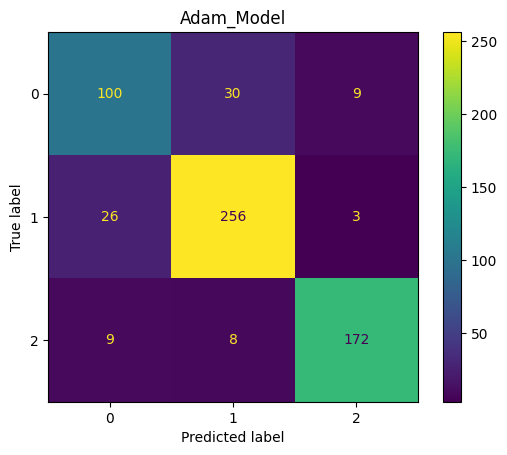

NAdam_Model: 


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test set: 81.23980712890625%
F1 score on test set: 0.8040334589009251
Log Loss on test set: 0.45892103250027594


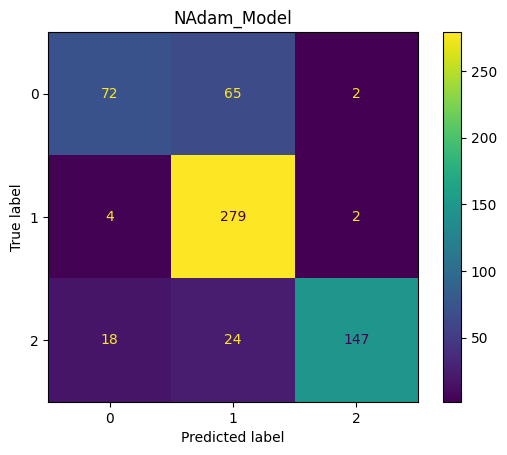

SGD_Model: 


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test set: 66.39478302001953%
F1 score on test set: 0.6591369033947583
Log Loss on test set: 0.8268909544008612


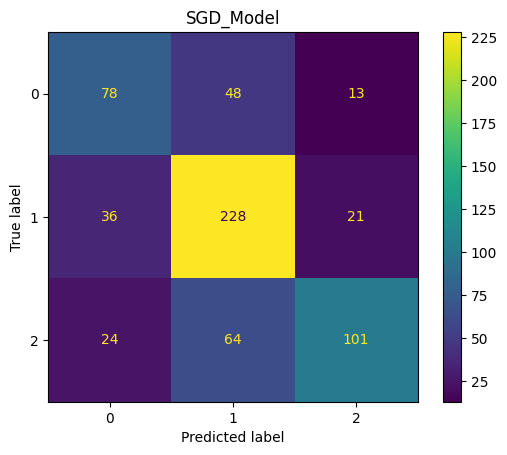

RMSprop_Model: 


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test set: 22.67536735534668%
F1 score on test set: 0.0838264898823366
Log Loss on test set: 1.1193549292477498


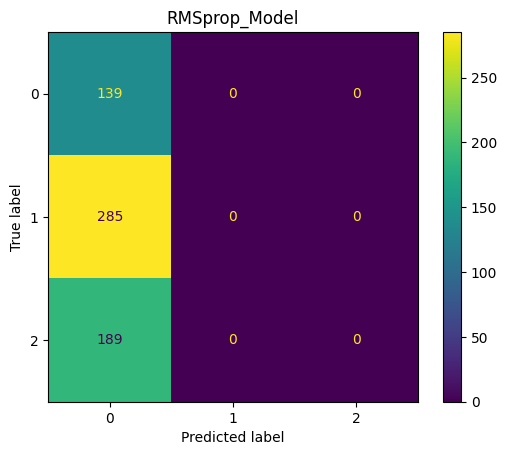

(array([[139,   0,   0],
        [285,   0,   0],
        [189,   0,   0]]),
 tensor(22.6754),
 0.0838264898823366,
 1.1193549292477498)

In [ ]:
print('Adam_Model: ')
test(adam_model, test_loader, model_name = 'Adam_Model', display = True)

print('NAdam_Model: ')
test(Nadam_model, test_loader, model_name = 'NAdam_Model', display = True)

print('SGD_Model: ')
test(sgd_model, test_loader, model_name = 'SGD_Model', display = True)

print('RMSprop_Model: ')
test(rms_model, test_loader, model_name = 'RMSprop_Model', display = True)

In [ ]:
lr_list = [1, .5, .2, .1, .05, .01, .005, .001]
m = [0, 0.2, 0.5, 0.7, 0.9, 1]
for lr in lr_list:
  for momentum in m:
    test_model = CNN()
    test_model_sgd = CNN()
    print()
    print('lr: ',lr, 'm: ', momentum)
    print()
    print('rms: ')
    rms_opt = torch.optim.RMSprop(test_model.parameters(),lr = lr, momentum = momentum)
    train(test_model, rms_opt,train_loader, epochs = 3)

    print()
    print('sgd: ')
    sgd_opt = torch.optim.SGD(test_model_sgd.parameters(), lr = lr, momentum = momentum)
    train(test_model_sgd, sgd_opt,train_loader, epochs = 3)


lr:  1 m:  0

rms: 


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/3] Loss: 4.740566730499268
Epoch [2/3] Loss: 0.8656845092773438
Epoch [3/3] Loss: 245908.265625
Accuracy on train set: 44.94764041887665%
training time: 6.319356270631155 minutes

sgd: 
Epoch [1/3] Loss: 1.0087674856185913
Epoch [2/3] Loss: 1.1386915445327759
Epoch [3/3] Loss: 1.08873450756073
Accuracy on train set: 46.28042975656195%
training time: 6.136339143911997 minutes

lr:  1 m:  0.2

rms: 
Epoch [1/3] Loss: 8687987.0
Epoch [2/3] Loss: 8765.0283203125
Epoch [3/3] Loss: 16250.9619140625
Accuracy on train set: 38.89568883448933%
training time: 6.160235758622488 minutes

sgd: 
Epoch [1/3] Loss: 0.9897747039794922
Epoch [2/3] Loss: 1.1847587823867798
Epoch [3/3] Loss: 1.3272775411605835
Accuracy on train set: 50.79559363525092%
training time: 6.103579250971476 minutes

lr:  1 m:  0.5

rms: 
Epoch [1/3] Loss: 1348733952.0
Epoch [2/3] Loss: 534750848.0
Epoch [3/3] Loss: 13366.5908203125
Accuracy on train set: 40.73167414660683%
training time: 6.158293835322062 minutes

sgd: 


FileNotFoundError: ignored

In [ ]:
lr_list = [.1, .05, .01, .005, .001]
m = [0, 0.2, 0.5, 0.7, 0.9, 1]
for lr in lr_list:
  for momentum in m:
    test_model = CNN()
    test_model_sgd = CNN()
    print()
    print('lr: ',lr, 'm: ', momentum)
    print()
    print('rms: ')
    rms_opt = torch.optim.RMSprop(test_model.parameters(),lr = lr, momentum = momentum)
    train(test_model, rms_opt,train_loader, epochs = 3)

    print()
    print('sgd: ')
    sgd_opt = torch.optim.SGD(test_model_sgd.parameters(), lr = lr, momentum = momentum)
    train(test_model_sgd, sgd_opt,train_loader, epochs = 3)


lr:  0.1 m:  0

rms: 
Epoch [1/3] Loss: 13.555278778076172
Epoch [2/3] Loss: 1.0184110403060913
Epoch [3/3] Loss: 0.9063370227813721
Accuracy on train set: 41.46606827145383%
training time: 6.920264848073324 minutes

sgd: 
Epoch [1/3] Loss: 1.0303053855895996
Epoch [2/3] Loss: 1.0786495208740234
Epoch [3/3] Loss: 1.1550923585891724
Accuracy on train set: 46.28042975656195%
training time: 6.907593750953675 minutes

lr:  0.1 m:  0.2

rms: 
Epoch [1/3] Loss: 1.1435507535934448
Epoch [2/3] Loss: 1.1153810024261475
Epoch [3/3] Loss: 0.929461658000946
Accuracy on train set: 42.89405684754522%
training time: 6.825949664910635 minutes

sgd: 
Epoch [1/3] Loss: 1.0297670364379883
Epoch [2/3] Loss: 1.0072033405303955
Epoch [3/3] Loss: 0.6692429780960083
Accuracy on train set: 53.32517339861281%
training time: 6.913746984799703 minutes

lr:  0.1 m:  0.5

rms: 
Epoch [1/3] Loss: 3.297140121459961
Epoch [2/3] Loss: 1.3284817934036255
Epoch [3/3] Loss: 1.7990971803665161
Accuracy on train set: 39.91

In [ ]:
adam_lr = .001
nadam_lr = .002

In [ ]:
model = CNN()
adam_opt_v2 = torch.optim.Adam(model.parameters(), lr = nadam_lr)
adam_model_v2 = train(model, adam_opt_v2,train_loader, epochs = 10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10] Loss: 1.0718774795532227
Epoch [2/10] Loss: 0.6986547112464905
Epoch [3/10] Loss: 0.609900951385498
Epoch [4/10] Loss: 0.30435094237327576
Epoch [5/10] Loss: 0.43053752183914185
Epoch [6/10] Loss: 0.597509503364563
Epoch [7/10] Loss: 0.6480781435966492
Epoch [8/10] Loss: 0.6270651817321777
Epoch [9/10] Loss: 0.3452615737915039
Epoch [10/10] Loss: 0.2694973051548004
Accuracy on train set: 75.84251325989392%
training time: 21.627575071652732 minutes


In [ ]:
modelSave(adam_model_v2, model_names[0]+'_V2')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test set: 82.05546569824219%
F1 score on test set: 0.8218720408103273
Log Loss on test set: 0.4116732112476312


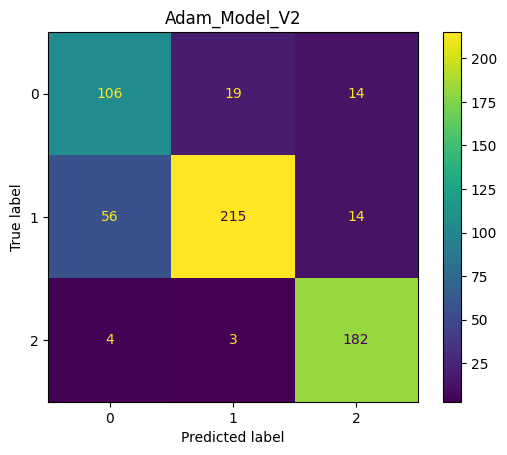

(array([[106,  19,  14],
        [ 56, 215,  14],
        [  4,   3, 182]]),
 tensor(82.0555),
 0.8218720408103273,
 0.4116732112476312)

In [ ]:
test(adam_model_v2, test_loader, model_name = 'Adam_Model_V2', display = True)

In [ ]:
model_1 = CNN()
Nadam_opt_v2 = torch.optim.NAdam(model_1.parameters(), lr = adam_lr)
Nadam_model_v2 = train(model_1, Nadam_opt_v2,train_loader, epochs = 10)

Epoch [1/10] Loss: 0.7525413632392883
Epoch [2/10] Loss: 0.6454053521156311
Epoch [3/10] Loss: 0.7346029877662659
Epoch [4/10] Loss: 0.5190042853355408
Epoch [5/10] Loss: 0.4292271137237549
Epoch [6/10] Loss: 0.78070467710495
Epoch [7/10] Loss: 0.3358505368232727
Epoch [8/10] Loss: 0.36749884486198425
Epoch [9/10] Loss: 0.24040871858596802
Epoch [10/10] Loss: 0.4658498167991638
Accuracy on train set: 74.27172582619339%
training time: 19.97337988615036 minutes


In [ ]:
modelSave(Nadam_model_v2, model_names[1]+'_V2')

Accuracy on test set: 75.8564453125%
F1 score on test set: 0.7738247361365805
Log Loss on test set: 0.5604738510252941


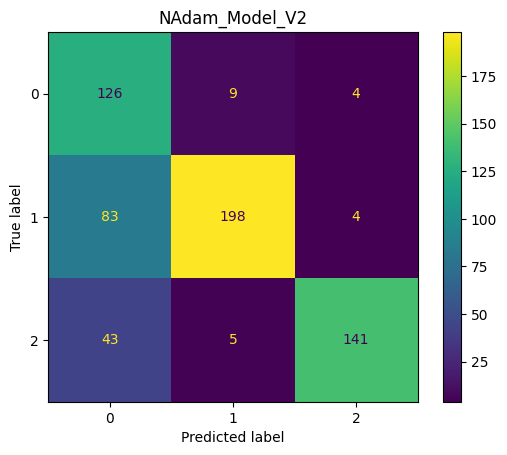

(array([[126,   9,   4],
        [ 83, 198,   4],
        [ 43,   5, 141]]),
 tensor(75.8564),
 0.7738247361365805,
 0.5604738510252941)

In [ ]:
test(Nadam_model_v2, test_loader, model_name = 'NAdam_Model_V2', display = True)

In [ ]:
model_2 = CNN()
sgd_opt_v2 = torch.optim.SGD(model_2.parameters(), lr = adam_lr)
sgd_model_v2 = train(model_2, sgd_opt_v2,train_loader, epochs = 10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10] Loss: 1.0979609489440918
Epoch [2/10] Loss: 1.1093642711639404
Epoch [3/10] Loss: 1.074414849281311
Epoch [4/10] Loss: 1.0773251056671143
Epoch [5/10] Loss: 1.1091340780258179
Epoch [6/10] Loss: 1.0915738344192505
Epoch [7/10] Loss: 1.0946732759475708
Epoch [8/10] Loss: 1.0835018157958984
Epoch [9/10] Loss: 1.0935965776443481
Epoch [10/10] Loss: 1.0826475620269775
Accuracy on train set: 43.88820889432885%
training time: 18.085606149832408 minutes


In [ ]:
modelSave(sgd_model_v2, model_names[2]+'_V2')

In [ ]:
sgd_model_v2 = modelLoad(model_names[2]+'_V2')

Accuracy on test set: 46.49266052246094%
F1 score on test set: 0.29510930579827566
Log Loss on test set: 1.0854048493298507


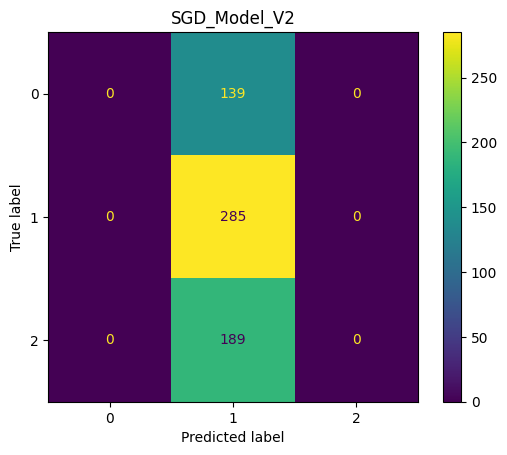

(array([[  0, 139,   0],
        [  0, 285,   0],
        [  0, 189,   0]]),
 tensor(46.4927),
 0.29510930579827566,
 1.0854048493298507)

In [ ]:
test(sgd_model_v2, test_loader, model_name = 'SGD_Model_V2', display = True)

In [ ]:
model_2 = CNN()
sgd_opt_v3 = torch.optim.SGD(model_2.parameters(), lr = nadam_lr)
sgd_model_v3 = train(model_2, sgd_opt_v3,train_loader, epochs = 10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10] Loss: 1.1001545190811157
Epoch [2/10] Loss: 1.0900547504425049
Epoch [3/10] Loss: 1.0621795654296875
Epoch [4/10] Loss: 1.082506775856018
Epoch [5/10] Loss: 1.0881630182266235
Epoch [6/10] Loss: 1.0617259740829468
Epoch [7/10] Loss: 1.0701149702072144
Epoch [8/10] Loss: 1.0404309034347534
Epoch [9/10] Loss: 1.0779153108596802
Epoch [10/10] Loss: 1.0302562713623047
Accuracy on train set: 46.552427580579355%
training time: 17.918689652283987 minutes


In [ ]:
modelSave(sgd_model_v3, model_names[2]+'_V3')

In [ ]:
sgd_model_v3 = modelLoad(model_names[2]+'_V3')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test set: 46.49266052246094%
F1 score on test set: 0.29510930579827566
Log Loss on test set: 1.081368318458784


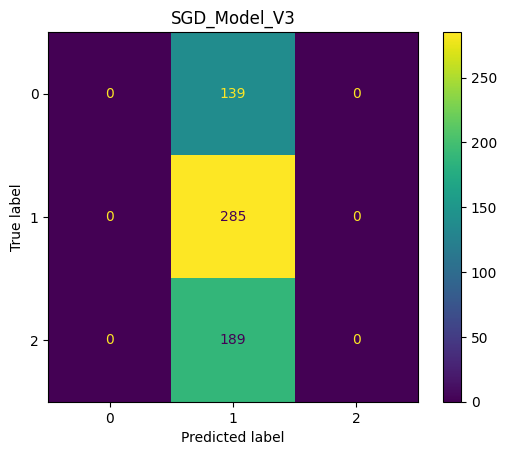

(array([[  0, 139,   0],
        [  0, 285,   0],
        [  0, 189,   0]]),
 tensor(46.4927),
 0.29510930579827566,
 1.081368318458784)

In [ ]:
test(sgd_model_v3, test_loader, model_name = 'SGD_Model_V3', display = True)

In [ ]:
model_3 = CNN()
rmsprop_opt_v2 = torch.optim.RMSprop(model_3.parameters(), lr = adam_lr)
rms_model_v2 = train(model_3, rmsprop_opt_v2,train_loader, epochs = 10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10] Loss: 1.0168750286102295
Epoch [2/10] Loss: 0.6038916110992432
Epoch [3/10] Loss: 0.4262261688709259
Epoch [4/10] Loss: 0.3290351927280426
Epoch [5/10] Loss: 0.4701942503452301
Epoch [6/10] Loss: 0.4264986217021942
Epoch [7/10] Loss: 0.17363664507865906
Epoch [8/10] Loss: 0.38130077719688416
Epoch [9/10] Loss: 0.4173947870731354
Epoch [10/10] Loss: 0.5496194958686829
Accuracy on train set: 78.8576091391269%
training time: 20.51218092441559 minutes


In [ ]:
modelSave(rms_model_v2, model_names[3]+'V2')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test set: 83.03425598144531%
F1 score on test set: 0.834223278125104
Log Loss on test set: 0.4244498213927826


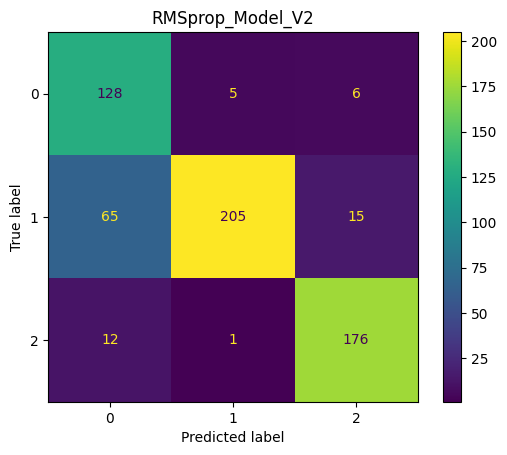

(array([[128,   5,   6],
        [ 65, 205,  15],
        [ 12,   1, 176]]),
 tensor(83.0343),
 0.834223278125104,
 0.4244498213927826)

In [ ]:
test(rms_model_v2, test_loader, model_name = 'RMSprop_Model_V2', display = True)

In [ ]:
model_3 = CNN()
rmsprop_opt_v3 = torch.optim.RMSprop(model_3.parameters(), lr = nadam_lr)
rms_model_v3 = train(model_3, rmsprop_opt_v3,train_loader, epochs = 10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10] Loss: 0.9990326762199402
Epoch [2/10] Loss: 1.0351024866104126
Epoch [3/10] Loss: 0.8653057217597961
Epoch [4/10] Loss: 0.5204229950904846
Epoch [5/10] Loss: 0.6127517819404602
Epoch [6/10] Loss: 0.4721401035785675
Epoch [7/10] Loss: 0.5066887140274048
Epoch [8/10] Loss: 0.491938978433609
Epoch [9/10] Loss: 0.2503547966480255
Epoch [10/10] Loss: 0.13103275001049042
Accuracy on train set: 76.7156262749898%
training time: 19.71572517156601 minutes


In [ ]:
modelSave(rms_model_v3, model_names[3]+'V3')

Accuracy on test set: 83.36051940917969%
F1 score on test set: 0.8316889793680539
Log Loss on test set: 0.42381296107875455


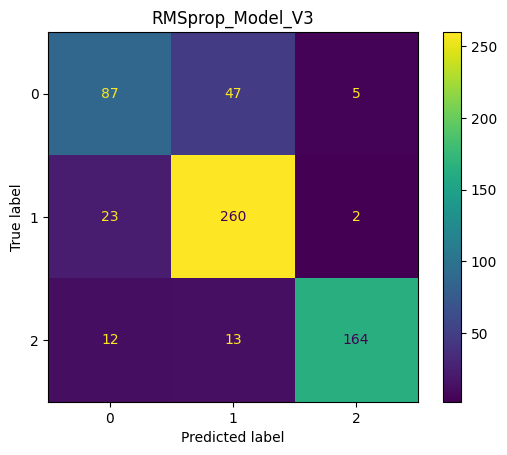

(array([[ 87,  47,   5],
        [ 23, 260,   2],
        [ 12,  13, 164]]),
 tensor(83.3605),
 0.8316889793680539,
 0.42381296107875455)

In [ ]:
test(rms_model_v3, test_loader, model_name = 'RMSprop_Model_V3', display = True)

In [ ]:
model_3 =CNN()
rmsprop_opt_v4 = torch.optim.RMSprop(model_3.parameters(), lr = .005)
rms_model_v4 = train(model_3, rmsprop_opt_v4,train_loader, epochs = 10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10] Loss: 1.2137715816497803
Epoch [2/10] Loss: 0.6140004396438599
Epoch [3/10] Loss: 0.6274464726448059
Epoch [4/10] Loss: 0.8400959968566895
Epoch [5/10] Loss: 0.44312116503715515
Epoch [6/10] Loss: 0.7612949013710022
Epoch [7/10] Loss: 0.4702742099761963
Epoch [8/10] Loss: 0.28908979892730713
Epoch [9/10] Loss: 0.7299573421478271
Epoch [10/10] Loss: 0.8025498390197754
Accuracy on train set: 70.70175438596492%
training time: 19.904526674747466 minutes


In [ ]:
modelSave(rms_model_v4, model_names[3]+'V4')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test set: 70.47308349609375%
F1 score on test set: 0.7029538115505637
Log Loss on test set: 0.6178125593513062


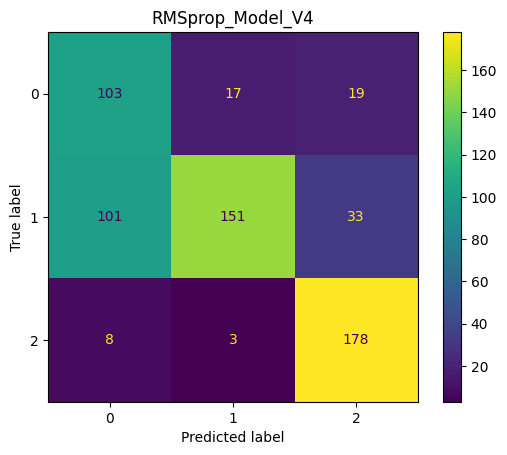

(array([[103,  17,  19],
        [101, 151,  33],
        [  8,   3, 178]]),
 tensor(70.4731),
 0.7029538115505637,
 0.6178125593513062)

In [ ]:
test(rms_model_v4, test_loader, model_name = 'RMSprop_Model_V4', display = True)

In [ ]:
model_2 = CNN()
sgd_opt_v4 = torch.optim.SGD(model_2.parameters(), lr = 0.2, momentum=0.2)
sgd_model = train(model_2, sgd_opt_v4,train_loader, epochs = 10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10] Loss: 1.0375674962997437
Epoch [2/10] Loss: 0.8157045245170593
Epoch [3/10] Loss: 1.0679376125335693
Epoch [4/10] Loss: 0.9655237793922424
Epoch [5/10] Loss: 0.7392976880073547
Epoch [6/10] Loss: 0.4728284180164337
Epoch [7/10] Loss: 0.4997718632221222
Epoch [8/10] Loss: 1.3044519424438477
Epoch [9/10] Loss: 0.6744673252105713
Epoch [10/10] Loss: 0.41652193665504456
Accuracy on train set: 62.86821705426357%
training time: 20.039482382933297 minutes


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test set: 76.01957702636719%
F1 score on test set: 0.7323365208771433
Log Loss on test set: 0.5087386743559571


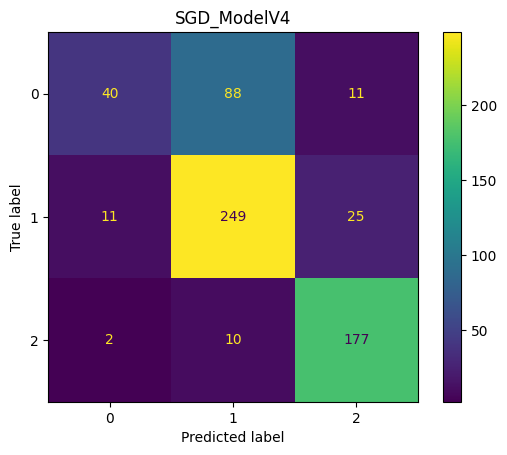

(array([[ 40,  88,  11],
        [ 11, 249,  25],
        [  2,  10, 177]]),
 tensor(76.0196),
 0.7323365208771433,
 0.5087386743559571)

In [ ]:
test(sgd_model, test_loader, model_name = model_names[2]+'V4', display = True)

In [ ]:
model_2 = CNN()
sgd_opt_v4 = torch.optim.SGD(model_2.parameters(), lr = 0.5)
sgd_model = train(model_2, sgd_opt_v4,train_loader, epochs = 10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10] Loss: 0.9921280741691589
Epoch [2/10] Loss: 1.1140388250350952
Epoch [3/10] Loss: 0.8564680218696594
Epoch [4/10] Loss: 0.8648643493652344
Epoch [5/10] Loss: 1.1353496313095093
Epoch [6/10] Loss: 0.903059184551239
Epoch [7/10] Loss: 0.861031174659729
Epoch [8/10] Loss: 0.7660484313964844
Epoch [9/10] Loss: 0.4265209436416626
Epoch [10/10] Loss: 0.5472256541252136
Accuracy on train set: 61.958384332925334%
training time: 20.861912790934245 minutes


Accuracy on test set: 74.55138397216797%
F1 score on test set: 0.753022120248434
Log Loss on test set: 0.6037095349158884


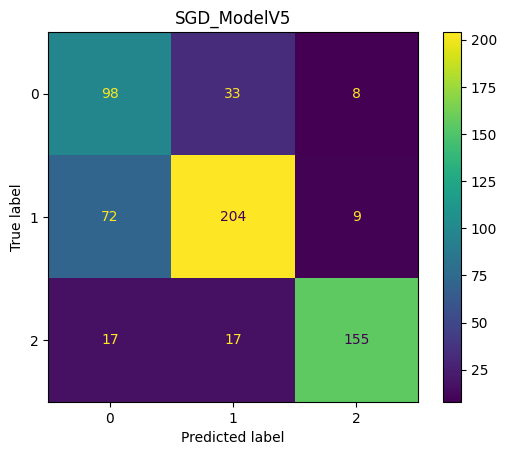

(array([[ 98,  33,   8],
        [ 72, 204,   9],
        [ 17,  17, 155]]),
 tensor(74.5514),
 0.753022120248434,
 0.6037095349158884)

In [ ]:
test(sgd_model, test_loader, model_name = model_names[2]+'V5', display = True)

In [ ]:
model = CNN()
adam_opt = torch.optim.Adam(model.parameters())
adam_model = train(model, adam_opt,train_loader, epochs = 10)

Epoch [1/10] Loss: 0.6970630884170532
Epoch [2/10] Loss: 0.6106553077697754
Epoch [3/10] Loss: 0.4726771414279938
Epoch [4/10] Loss: 0.25800299644470215
Epoch [5/10] Loss: 0.3886115252971649
Epoch [6/10] Loss: 0.6536809802055359
Epoch [7/10] Loss: 0.33736348152160645
Epoch [8/10] Loss: 0.3753603398799896
Epoch [9/10] Loss: 0.2247539758682251
Epoch [10/10] Loss: 0.3751855790615082
Accuracy on train set: 77.06650346797225%
training time: 19.001130815347036 minutes


In [ ]:
model_2 = CNN()
sgd_opt_v4 = torch.optim.SGD(model_2.parameters(), lr = 0.1, momentum=0.9)
sgd_model = train(model_2, sgd_opt_v4,train_loader, epochs = 10)

Epoch [1/10] Loss: 1.0792896747589111
Epoch [2/10] Loss: 0.9025675058364868
Epoch [3/10] Loss: 1.088984489440918
Epoch [4/10] Loss: 1.2052268981933594
Epoch [5/10] Loss: 0.9649989604949951
Epoch [6/10] Loss: 1.0812915563583374
Epoch [7/10] Loss: 1.110072135925293
Epoch [8/10] Loss: 1.0170639753341675
Epoch [9/10] Loss: 0.9743034839630127
Epoch [10/10] Loss: 0.9387218952178955
Accuracy on train set: 47.5234598123215%
training time: 22.30177592833837 minutes


Accuracy on test set: 46.49266052246094%
F1 score on test set: 0.29510930579827566
Log Loss on test set: 1.056759641937243


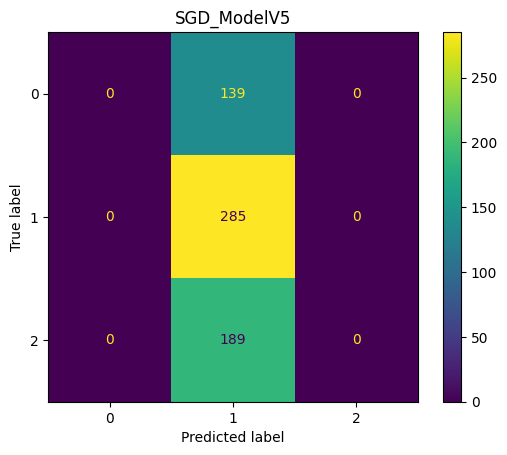

(array([[  0, 139,   0],
        [  0, 285,   0],
        [  0, 189,   0]]),
 tensor(46.4927),
 0.29510930579827566,
 1.056759641937243)

In [ ]:
test(sgd_model, test_loader, model_name = model_names[2], display = True)

In [ ]:
model_3 =CNN()
rmsprop_opt_v4 = torch.optim.RMSprop(model_3.parameters(), lr = .001, momentum=0.7)
train(model_3, rmsprop_opt_v4,train_loader, epochs = 10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10] Loss: 1.1686347723007202
Epoch [2/10] Loss: 0.5947235822677612
Epoch [3/10] Loss: 0.6384275555610657
Epoch [4/10] Loss: 0.6091074347496033
Epoch [5/10] Loss: 0.3487387001514435
Epoch [6/10] Loss: 0.7339694499969482
Epoch [7/10] Loss: 0.5582610964775085
Epoch [8/10] Loss: 0.5243992209434509
Epoch [9/10] Loss: 0.30073297023773193
Epoch [10/10] Loss: 0.2998429238796234
Accuracy on train set: 76.6217870257038%
training time: 22.923621825377147 minutes


CNN(
  (conv1): Conv2d(3, 6, kernel_size=(9, 9), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

Accuracy on test set: 85.15497589111328%
F1 score on test set: 0.852007400544723
Log Loss on test set: 0.37726196736369744


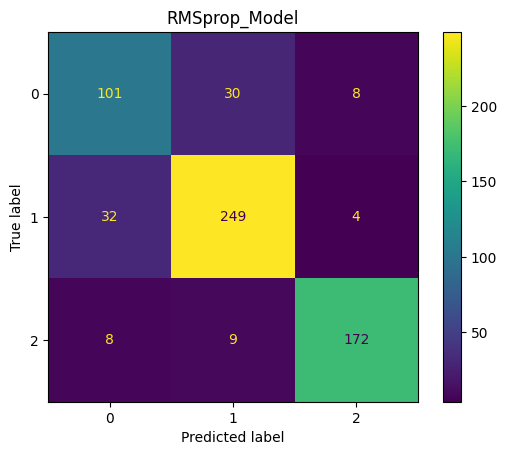

(array([[101,  30,   8],
        [ 32, 249,   4],
        [  8,   9, 172]]),
 tensor(85.1550),
 0.852007400544723,
 0.37726196736369744)

In [ ]:
test(model_3, test_loader, model_name = 'RMSprop_Model', display = True)